<a href="https://colab.research.google.com/github/jchooch/comp_neuro/blob/main/neuronal_sims.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Neuronal Simulations
Joe Choo-Choy

In [ ]:
!pip install brian2

In [ ]:
from brian2 import *
import time
import numpy as np
import matplotlib.pyplot as plt

## The Linear Integrate-and-Fire Neuron Model

### Without Refractory Period

In [ ]:
start_scope()

start = time.time()
num_neurons = 100

# Parameters
area=20000*umetre**2
Cm = 1*ufarad*cm**-2
El = -10*mV
E_rest = -60*mV

gl = 0.3*(msiemens)/(cm**2)
defaultclock.dt=.01*ms
div=defaultclock.dt

#The model
eqs_il = '''
    il = gl * (El-v) :amp/meter**2
    '''

eqs = '''
    dv/dt = (il +I/area)/Cm :  volt
    I : amp
    '''
eqs += eqs_il

# Threshold and refractoriness are only used for spike counting
group = NeuronGroup(num_neurons, eqs,clock=Clock(defaultclock.dt),
                    threshold='v > -40*mV',
                    reset = 'v = E_rest', refractory='v > -40*mV',
                    method='exponential_euler')
group.v = -60*mV

monitor = SpikeMonitor(group)
monitor2=StateMonitor(group,'v',record=True)

group.I = '(5.0 * nA * i) / num_neurons'
run(100*ms, report='text')

Starting simulation at t=0. s for a duration of 100. ms
100. ms (100%) simulated in < 1s


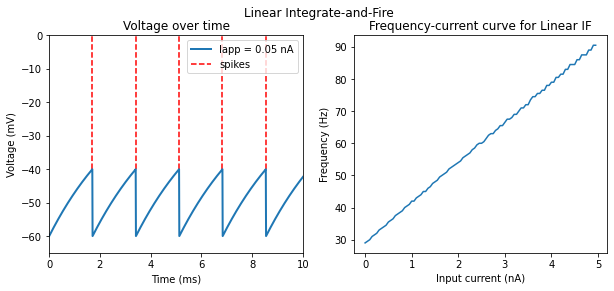

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Linear Integrate-and-Fire')

ax1.plot(monitor2.t/ms, monitor2[0].v/mV, linewidth=2)
spikes = np.argwhere(monitor2.v[0]/mV > -40.1)

for i in spikes[:5]:
  ax1.vlines(i/100, -40, 0, colors='r', linestyles='--')
  
ax1.set_ylim(-65,0) #set axes limits
ax1.set_xlim(0,10)
ax1.legend(['Iapp = 0.05 nA', 'spikes'])
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (mV)')
ax1.set_title('Voltage over time')

ax2.plot(group.I/nA, (monitor.count / (2000*ms)))
ax2.set_title('Frequency-current curve for Linear IF')
ax2.set_xlabel('Input current (nA)')
ax2.set_ylabel('Frequency (Hz)')

fig.show()

### With Refractory Period

In [ ]:
start_scope()

start = time.time()
num_neurons = 100

# Parameters
area=20000*umetre**2
Cm = 1*ufarad*cm**-2
El = -10*mV
E_rest = -60*mV
t_ref = 1*ms

gl = 0.3*(msiemens)/(cm**2)
defaultclock.dt=.01*ms
div=defaultclock.dt

#The model
eqs_il = '''
    il = gl * (El-v) :amp/meter**2
    '''

eqs = '''
    dv/dt = (il +I/area)/Cm :  volt (unless refractory)
    I : amp
    '''
eqs += eqs_il

# Threshold and refractoriness are only used for spike counting
group = NeuronGroup(num_neurons, eqs,clock=Clock(defaultclock.dt),
                    threshold='v > -40*mV',
                    reset = 'v = E_rest', refractory=t_ref,
                    method='exponential_euler')
group.v = -60*mV

monitor = SpikeMonitor(group)
monitor2=StateMonitor(group,'v',record=True)

group.I = '(5.0 * nA * i) / num_neurons'
run(500*ms, report='text')

WARNING    "i" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value array([683]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 2s


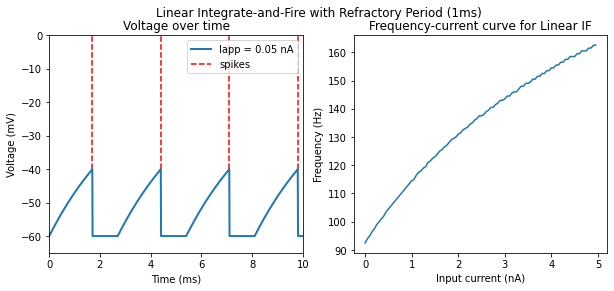

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Linear Integrate-and-Fire with Refractory Period (1ms)')

ax1.plot(monitor2.t/ms, monitor2[0].v/mV, linewidth=2)

spikes = np.argwhere(monitor2.v[0]/mV > -40.1)
for i in spikes[:4]:
  ax1.vlines(i/100, -40, 0, colors='r', linestyles='--')

ax1.set_ylim(-65,0) #set axes limits
ax1.set_xlim(0,10)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (mV)')
ax1.legend(['Iapp = 0.05 nA', 'spikes'])
ax1.set_title('Voltage over time')

ax2.plot(group.I/nA, (monitor.count / (2000*ms)))
ax2.set_title('Frequency-current curve for Linear IF')
ax2.set_xlabel('Input current (nA)')
ax2.set_ylabel('Frequency (Hz)')

fig.show()

## The Izhikevich Neuron Model

In [ ]:
num_neurons = 100
defaultclock.dt = 0.001*ms
duration = 200*ms

##############  ALTER MODE TO CHANGE IZHIKEVICH NEURON TYPE ###############
mode = 0            # (0, 1, 2, 3) -> (RS, IB, CH, FS) 
###########################################################################

ntype = {0 : 'RS', 1 : 'IB', 2 : 'CH', 3 : 'FS'}

vrest = -70*mV
vmax = 30*mV

if mode == 0: # regular spiking
  a = 0.02/ms
  b = 0.2/ms
  c = -65*mV
  d = 8*mV/ms
elif mode == 1: # intrinsically bursting
  a = 0.02/ms
  b = 0.2/ms
  c = -55*mV
  d = 4*mV/ms
elif mode == 2: # chattering
  a = 0.02/ms
  b = 0.2/ms
  c = -50*mV
  d = 2*mV/ms
elif mode == 3: # fast spiking
  a = 0.1/ms
  b = 0.2/ms
  c = -65*mV
  d = 2*mV/ms
else:
  print('Mode out of bounds. Must be in {0, 1, 2, 3}, corresponding to {RS, IB, CH, FS}.')

# Threshold
resets = '''
v = c
u = u + d
'''

# Model
eqs = '''
dv/dt = (0.04/ms/mV)*v**2 + (5/ms)*v + 140*mV/ms - u + I : volt
du/dt = a * (b * v - u) : volt/second
I : volt/second
'''

group_iz = NeuronGroup(num_neurons, eqs, clock=Clock(defaultclock.dt), threshold='v > vmax', 
                       reset = resets, method='euler')

group_iz.v = vrest
group_iz.u = b * c

monitor_iz = StateMonitor(group_iz, 'v', record=True)
monitor2_iz = SpikeMonitor(group_iz)
net_iz = Network(group_iz, monitor_iz, monitor2_iz)

# Timecourse
group_iz.I = '(20 * mV / ms * i) / num_neurons'
net_iz.run(duration)

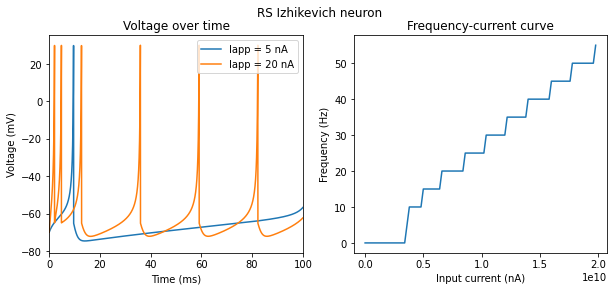

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('{:} Izhikevich neuron'.format(ntype[mode]))

ax1.plot(monitor_iz.t/ms, monitor_iz.v[24]/mV, label='Iapp = 5 nA')
ax1.plot(monitor_iz.t/ms, monitor_iz.v[99]/mV, label='Iapp = 20 nA')
#ax1.set_ylim(-65,0) #set axes limits
ax1.legend()
ax1.set_xlim(0,100)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (mV)')
ax1.set_title('Voltage over time')

ax2.plot(group_iz.I/nA, monitor2_iz.count / duration)
ax2.set_title('Frequency-current curve')
ax2.set_xlabel('Input current (nA)')
ax2.set_ylabel('Frequency (Hz)')

fig.show()

## A Biophysical Pyramidal Cell Model

In [ ]:
num_neurons = 100
duration_pyr = 2.0*second

# Parameters
area = 20000*umetre**2
Cm = (1*ufarad*cm**-2)

defaultclock.dt=.02*ms
div=defaultclock.dt

# The model
ENa=50.0 *mV
gnabar=50*msiemens*cm**-2
VT1=-61.5
VT=-61.5
EK=-90.0*mV
gkbar=4.8*msiemens*cm**-2
EKm=-90.0*mV
glbar= 0.0205*msiemens/cm**2
El=-70*mV
gmbar=0.15*msiemens/cm**2 #aka gkmbar...?
tau_max = 1123.5*ms

eqs_na = """
ina = gnabar*m**3*h*(ENa-v) : amp/meter**2
dm/dt  = (am1*(1-m)-bm1*m): 1
dh/dt  = (ah1*(1-h)-bh1*h): 1
am1=0.32*(13-(vu-VT))/(exp((13-(vu-VT))/4.0)-1.0)/ms: Hz
bm1=(0.28*((vu-VT)-40)/(exp(((vu-VT)-40)/5.0)-1.0))/ms: Hz
ah1 = 0.128*exp(-(vu-17-VT)/18)/ms: Hz
bh1 = 4/(1+exp(-(vu-40-VT)/5))/ms: Hz
"""

# IM channel ()
eqs_m = """
im = gmbar*p*(EKm-v) : amp/meter**2
dp/dt = (p_infty - p) / tau_p : 1
p_infty = 1 / (1 + exp( (-(v/mV) + 35) / 10)) : 1
tau_p = tau_max / (3.3 * exp((v/mV + 35) / 20) + exp((-(v/mV) + 35) / 10)) : second
"""

# K channel 
eqs_k = """
ik = gkbar*b**4*(EK-v): amp/meter**2
db/dt  = (ab*(1-b)-bb*b): 1
ab=0.032*(vu-15-VT1)/(1.0 - exp(-(vu-15-VT1)/5.0))/ms:Hz
bb=0.5*exp(-(vu-10-VT1)/40)/ms : Hz
"""

# Leak
eqs_leak = """
il = glbar*(El-v) : amp/meter**2
"""

eqs = """
dv/dt = (il + ik+ +ina+ im + I/area)/Cm : volt
vu = v/mV : 1  # unitless v 
I: amp
"""
eqs += eqs_leak + eqs_k + eqs_na +eqs_m


# Threshold and refractoriness are only used for spike counting
group3 = NeuronGroup(num_neurons, eqs,clock=Clock(defaultclock.dt),
                    threshold='v > -40*mV',refractory='v > -40*mV',method='euler')

group3.I='(7*nA * i) / num_neurons'

monitor_pyr = SpikeMonitor(group3)
monitor2_pyr = StateMonitor(group3, ('v', 'ik', 'il', 'im', 'ina'), record=True)
net_pyr = Network(group3, monitor_pyr, monitor2_pyr)
net_pyr.run(duration_pyr)

WARNING    The expression "1 / 4" divides two integer values. In previous versions of Brian, this would have used either an integer ("flooring") or a floating point division, depending on the Python version and the code generation target. In the current version, it always uses a floating point division. Explicitly ask for an  integer division ("//"), or turn one of the operands into a floating point value (e.g. replace "1/2" by "1.0/2") to no longer receive this warning. [brian2.parsing.bast.floating_point_division]
WARNING    The expression "17 / 18" divides two integer values. In previous versions of Brian, this would have used either an integer ("flooring") or a floating point division, depending on the Python version and the code generation target. In the current version, it always uses a floating point division. Explicitly ask for an  integer division ("//"), or turn one of the operands into a floating point value (e.g. replace "1/2" by "1.0/2") to no longer receive this warning. 

Text(0.5, 50.99999999999994, 'Time (ms)')

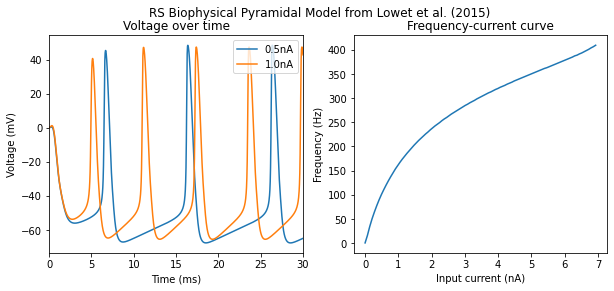

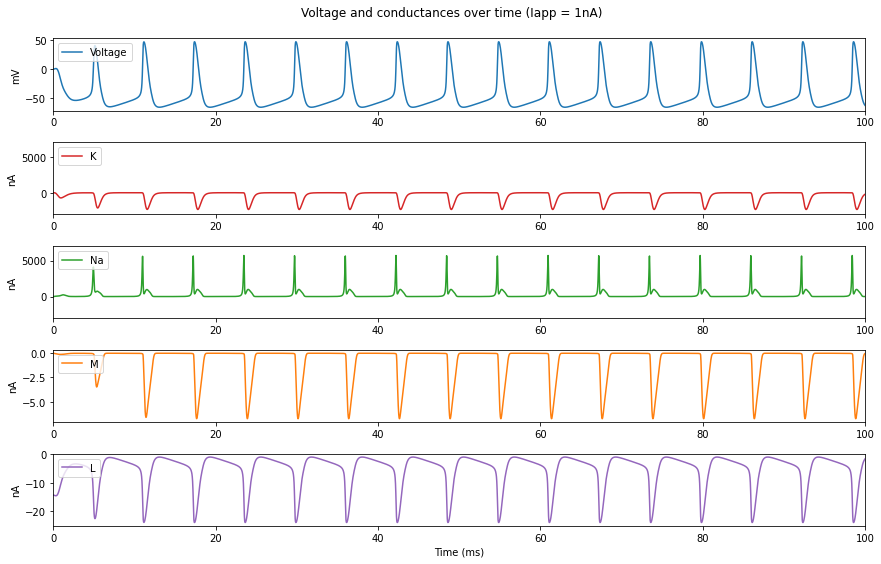

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('RS Biophysical Pyramidal Model from Lowet et al. (2015)')

ax1.plot(monitor2_pyr.t/ms, monitor2_pyr.v[7]/mV, label='0.5nA')
ax1.plot(monitor2_pyr.t/ms, monitor2_pyr.v[14]/mV, label='1.0nA')
#ax1.set_ylim(-65,0) #set axes limits
ax1.set_xlim(0,30)
ax1.legend(loc=1)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (mV)')
ax1.set_title('Voltage over time')

ax2.plot(group3.I/nA, monitor_pyr.count / duration_pyr)
ax2.set_title('Frequency-current curve')
ax2.set_xlabel('Input current (nA)')
ax2.set_ylabel('Frequency (Hz)')

fig.show()

fig, axs = plt.subplots(5)
fig.set_size_inches(12,8)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Voltage and conductances over time (Iapp = 1nA)')

axs[0].plot(monitor2_pyr.t/ms, monitor2_pyr.v[14]/mV, 'tab:blue', label='Voltage')
axs[0].set_xlim([0, 100])
axs[0].set_ylabel('mV')
axs[0].legend(loc=2)

axs[1].plot(monitor2_pyr.t/ms, monitor2_pyr.ik[14]/mV, 'tab:red', label='K')
axs[1].set_xlim([0, 100])
axs[1].set_ylabel('nA')
axs[1].set_ylim([-3000, 7000])
axs[1].legend(loc=2)

axs[2].plot(monitor2_pyr.t/ms, monitor2_pyr.ina[14]/mV, 'tab:green', label='Na')
axs[2].set_xlim([0, 100])
axs[2].set_ylabel('nA')
axs[2].set_ylim([-3000, 7000])
axs[2].legend(loc=2)

axs[3].plot(monitor2_pyr.t/ms, monitor2_pyr.im[14]/mV, 'tab:orange', label='M')
axs[3].set_xlim([0, 100])
axs[3].set_ylabel('nA')
#axs[3].set_ylim([-3000, 7000])
axs[3].legend(loc=2)

axs[4].plot(monitor2_pyr.t/ms, monitor2_pyr.il[14]/mV, 'tab:purple', label='L')
axs[4].set_xlim([0, 100])
axs[4].set_ylabel('nA')
#axs[4].set_ylim([-3000, 7000])
axs[4].legend(loc=2)
axs[4].set_xlabel('Time (ms)')


## A Synaptic Model of GABA and AMPA Receptors

### Excitatory Input Only

In [ ]:
start_scope()

defaultclock.dt=0.01*ms
num_neurons = 3
duration = 0.02*second

# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2
El = -60*mV
gl = 0.7*msiemens/cm**2
g_synpk=1.5

eqs_il = '''
il = gl * (El - v) : amp/meter**2
'''

eqs_iAMPA = '''
iAMPA = GAMPA * g_synpk * msiemens/cm**2 * (0 * mV - v) : amp/meter**2
GAMPA : 1
'''

eqs_iGABA = '''
iGABA = GGABA * g_synpk * msiemens/cm**2 * (- 80 * mV - v) : amp/meter**2
GGABA : 1
'''

eqs = '''
dv/dt = (il + iAMPA + iGABA + I/area) / Cm : volt
I : amp
'''

eqs += (eqs_il + eqs_iAMPA + eqs_iGABA)

# Threshold and refractoriness are only used for spike counting
group_ab = NeuronGroup(num_neurons, eqs, clock=Clock(defaultclock.dt),
                       threshold='v > -45*mV',reset='v = -60*mV', method='euler')
group_ab.v = El

# GAMPA and GGABA are the s values for each of the synaptic currents
Sr_ab_in = Synapses(group_ab, group_ab, clock=group_ab.clock,method='euler',model='''
                Trpre=.25*(tanh((t/ms-tspike/ms)/.005)-tanh((t/ms-(tspike/ms +.3))/.005)):1
                tspike: second
                aGABA = 5/ms : Hz
                bGABA = 0.18/ms : Hz
                dsGABA_syn/dt = aGABA*Trpre*(1-sGABA_syn)-bGABA*sGABA_syn:1
                GGABA_post = sGABA_syn : 1 (summed)''',
                on_pre='''tspike=t''')

Sr_ab_ex = Synapses(group_ab, group_ab, clock=group_ab.clock,method='euler',model='''
                Trpre=.25*(tanh((t/ms-tspike/ms)/.005)-tanh((t/ms-(tspike/ms +.3))/.005)):1
                tspike: second
                aAMPA=0.94/ms : Hz
                bAMPA=0.19/ms: Hz
                dsAMPA_syn/dt = aAMPA*Trpre*(1-sAMPA_syn)-bAMPA*sAMPA_syn:1
                GAMPA_post = sAMPA_syn : 1 (summed)''',
                on_pre='''tspike=t''')

Sr_ab_in.connect(i=[0],j=[2])   # inhibitory connection from (presyn) neuron 0
Sr_ab_ex.connect(i=[1], j=[2])  # excitatory connection from (presyn) neuron 1
Sr_ab_in.tspike[0]=-0.5*ms # needed to get rid of spurious first tspike
Sr_ab_ex.tspike[0]=-0.5*ms # needed to get rid of spurious first tspike
Sr_ab_in.delay=0*ms #introduces a fixed delay between the firing of the pre cell  and the postsynaptic response
Sr_ab_ex.delay=0*ms #introduces a fixed delay between the firing of the pre cell  and the postsynaptic response

monitor_ab = StateMonitor(group_ab,('I', 'v', 'GAMPA', 'GGABA', 'iAMPA', 'iGABA'),record=True)
monitor2_ab = SpikeMonitor(group_ab)
net_ab = Network(group_ab, monitor_ab, monitor2_ab, Sr_ab_in, Sr_ab_ex)

group_ab.I[0] = 0*nA
group_ab.I[1] = 0*nA
group_ab.I[2] = 0*nA
net_ab.run(3.0*ms,report='text')
group_ab.I[0] = 0*nA  # inhibitory
group_ab.I[1] = 8*nA  # excitatory
group_ab.I[2] = 0*nA
net_ab.run(1.0*ms, report='text')
group_ab.I[0] = 0*nA
group_ab.I[1] = 0*nA
group_ab.I[2] = 0*nA
net_ab.run(4.0*ms)

INFO       The synaptic equation for the variable sGABA_syn does not specify whether it should be integrated at every timestep ("clock-driven") or only at spiking events ("event-driven"). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable sAMPA_syn does not specify whether it should be integrated at every timestep ("clock-driven") or only at spiking events ("event-driven"). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]


Starting simulation at t=0. s for a duration of 3. ms
3. ms (100%) simulated in < 1s
Starting simulation at t=3. ms for a duration of 1. ms
1. ms (100%) simulated in < 1s


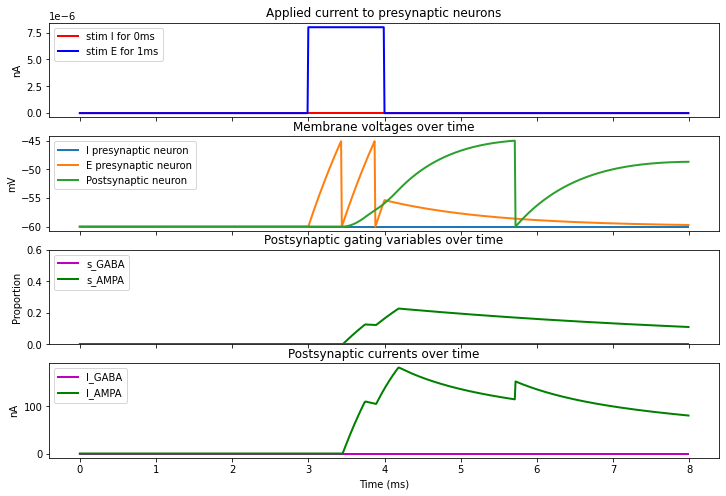

In [ ]:
figure(1, figsize=(12, 8))
subplot(4,1,1)
title('Applied current to presynaptic neurons')
plot(monitor_ab.t/ms, monitor_ab.I[0]/mV, 'r', linewidth=2, label='stim I for 0ms')
plot(monitor_ab.t/ms, monitor_ab.I[1]/mV, 'b', linewidth=2, label='stim E for 1ms')
ylabel('nA')
legend(loc=2)
ax = plt.gca()
ax.axes.set_xticklabels([])
subplot(4,1,2)
title('Membrane voltages over time')
plot(monitor_ab.t/ms, monitor_ab.v[0]/mV, linewidth=2, label='I presynaptic neuron')
plot(monitor_ab.t/ms, monitor_ab.v[1]/mV, linewidth=2, label='E presynaptic neuron')
plot(monitor_ab.t/ms, monitor_ab.v[2]/mV, linewidth=2, label='Postsynaptic neuron')
legend(loc=2)
ylabel('mV')
ax = plt.gca()
ax.axes.set_xticklabels([])
subplot(4,1,3)
title('Postsynaptic gating variables over time')
plot(monitor_ab.t/ms, monitor_ab.GGABA[2], 'm', linewidth=2, label='s_GABA')
plot(monitor_ab.t/ms, monitor_ab.GAMPA[2], 'green', linewidth=2, label='s_AMPA')
legend(loc=2)
ylim(0, 0.6)
ylabel('Proportion')
ax = plt.gca()
ax.axes.set_xticklabels([])
subplot(4,1,4)
title('Postsynaptic currents over time')
plot(monitor_ab.t/ms, monitor_ab.iGABA[2]/mV, 'm', linewidth=2, label='I_GABA')
plot(monitor_ab.t/ms, monitor_ab.iAMPA[2]/mV, 'green', linewidth=2, label='I_AMPA')
legend(loc=2)
#ylim(0, 450)
ylabel('nA')
xlabel('Time (ms)')
ax = plt.gca()

### Inhibitory Input Then Excitatory Input

In [ ]:
start_scope()

defaultclock.dt=0.01*ms
num_neurons = 3
duration = 0.02*second

# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2
El = -60*mV
gl = 0.7*msiemens/cm**2
g_synpk=1.5

eqs_il = '''
il = gl * (El - v) : amp/meter**2
'''

eqs_iAMPA = '''
iAMPA = GAMPA * g_synpk * msiemens/cm**2 * (0 * mV - v) : amp/meter**2
GAMPA : 1
'''

eqs_iGABA = '''
iGABA = GGABA * g_synpk * msiemens/cm**2 * (-80 * mV - v) : amp/meter**2
GGABA : 1
'''

eqs = '''
dv/dt = (il + iAMPA + iGABA + I/area) / Cm : volt
I : amp
'''

eqs += (eqs_il + eqs_iAMPA + eqs_iGABA)

# Threshold and refractoriness are only used for spike counting
group_ab = NeuronGroup(num_neurons, eqs, clock=Clock(defaultclock.dt),
                       threshold='v > -45*mV',reset='v = -60*mV', method='euler')
group_ab.v = El

# GAMPA and GGABA are the s values for each of the synaptic currents
Sr_ab_in = Synapses(group_ab, group_ab, clock=group_ab.clock,method='euler',model='''
                Trpre=.25*(tanh((t/ms-tspike/ms)/.005)-tanh((t/ms-(tspike/ms +.3))/.005)):1
                tspike: second
                aGABA = 5/ms : Hz
                bGABA = 0.18/ms : Hz
                dsGABA_syn/dt = aGABA*Trpre*(1-sGABA_syn)-bGABA*sGABA_syn:1
                GGABA_post = sGABA_syn : 1 (summed)''',
                on_pre='''tspike=t''')

Sr_ab_ex = Synapses(group_ab, group_ab, clock=group_ab.clock,method='euler',model='''
                Trpre=.25*(tanh((t/ms-tspike/ms)/.005)-tanh((t/ms-(tspike/ms +.3))/.005)):1
                tspike: second
                aAMPA=0.94/ms : Hz
                bAMPA=0.19/ms: Hz
                dsAMPA_syn/dt = aAMPA*Trpre*(1-sAMPA_syn)-bAMPA*sAMPA_syn:1
                GAMPA_post = sAMPA_syn : 1 (summed)''',
                on_pre='''tspike=t''')

Sr_ab_in.connect(i=[0],j=[2])   # inhibitory connection from (presyn) neuron 0
Sr_ab_ex.connect(i=[1], j=[2])  # excitatory connection from (presyn) neuron 1
Sr_ab_in.tspike[0]=-0.5*ms # needed to get rid of spurious first tspike
Sr_ab_ex.tspike[0]=-0.5*ms # needed to get rid of spurious first tspike
Sr_ab_in.delay=0*ms #introduces a fixed delay between the firing of the pre cell  and the postsynaptic response
Sr_ab_ex.delay=0*ms #introduces a fixed delay between the firing of the pre cell  and the postsynaptic response

monitor_ab = StateMonitor(group_ab,('I', 'v', 'GAMPA', 'GGABA', 'iAMPA', 'iGABA'),record=True)
monitor2_ab = SpikeMonitor(group_ab)
net_ab = Network(group_ab, monitor_ab, monitor2_ab, Sr_ab_in, Sr_ab_ex)

group_ab.I[0] = 0*nA
group_ab.I[1] = 0*nA
group_ab.I[2] = 0*nA
net_ab.run(2.0*ms,report='text')
group_ab.I[0] = 8*nA
group_ab.I[1] = 0*nA
group_ab.I[2] = 0*nA
net_ab.run(0.5*ms,report='text')
group_ab.I[0] = 0*nA
group_ab.I[1] = 0*nA
group_ab.I[2] = 0*nA
net_ab.run(0.5*ms,report='text')
group_ab.I[0] = 0*nA  # inhibitory
group_ab.I[1] = 8*nA  # excitatory
group_ab.I[2] = 0*nA
net_ab.run(2.7*ms, report='text')
group_ab.I[0] = 0*nA
group_ab.I[1] = 0*nA
group_ab.I[2] = 0*nA
net_ab.run(2.5*ms)

Starting simulation at t=0. s for a duration of 2. ms
2. ms (100%) simulated in < 1s
Starting simulation at t=2. ms for a duration of 0.5 ms
0.5 ms (100%) simulated in < 1s
Starting simulation at t=2.5 ms for a duration of 0.5 ms
0.5 ms (100%) simulated in < 1s
Starting simulation at t=3. ms for a duration of 2.7 ms
2.7 ms (100%) simulated in < 1s


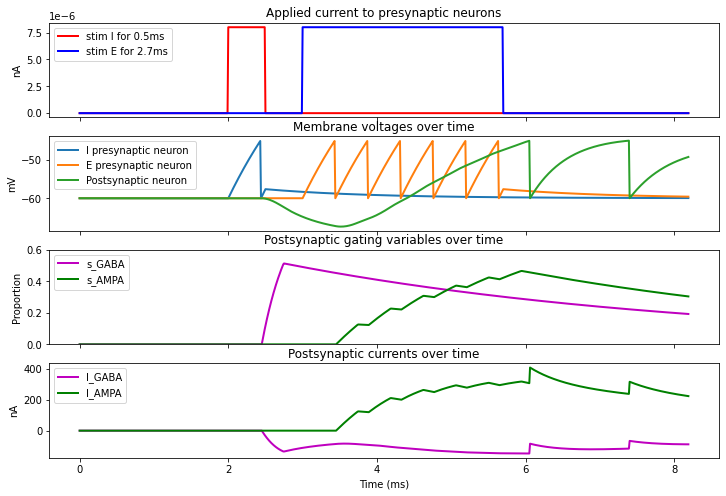

In [ ]:
figure(1, figsize=(12, 8))
subplot(4,1,1)
title('Applied current to presynaptic neurons')
plot(monitor_ab.t/ms, monitor_ab.I[0]/mV, 'r', linewidth=2, label='stim I for 0.5ms')
plot(monitor_ab.t/ms, monitor_ab.I[1]/mV, 'b', linewidth=2, label='stim E for 2.7ms')
ylabel('nA')
legend(loc=2)
ax = plt.gca()
ax.axes.set_xticklabels([])
subplot(4,1,2)
title('Membrane voltages over time')
plot(monitor_ab.t/ms, monitor_ab.v[0]/mV, linewidth=2, label='I presynaptic neuron')
plot(monitor_ab.t/ms, monitor_ab.v[1]/mV, linewidth=2, label='E presynaptic neuron')
plot(monitor_ab.t/ms, monitor_ab.v[2]/mV, linewidth=2, label='Postsynaptic neuron')
legend(loc=2)
ylabel('mV')
ax = plt.gca()
ax.axes.set_xticklabels([])
subplot(4,1,3)
title('Postsynaptic gating variables over time')
plot(monitor_ab.t/ms, monitor_ab.GGABA[2], 'm', linewidth=2, label='s_GABA')
plot(monitor_ab.t/ms, monitor_ab.GAMPA[2], 'green', linewidth=2, label='s_AMPA')
legend(loc=2)
ylim(0, 0.6)
ylabel('Proportion')
ax = plt.gca()
ax.axes.set_xticklabels([])
subplot(4,1,4)
title('Postsynaptic currents over time')
plot(monitor_ab.t/ms, monitor_ab.iGABA[2]/mV, 'm', linewidth=2, label='I_GABA')
plot(monitor_ab.t/ms, monitor_ab.iAMPA[2]/mV, 'green', linewidth=2, label='I_AMPA')
legend(loc=2)
#ylim(0, 450)
ylabel('nA')
xlabel('Time (ms)')
ax = plt.gca()